## Loading the required libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.impute import SimpleImputer
from sklearn import metrics
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from tabulate import tabulate
import warnings
warnings.filterwarnings("ignore")

## Loading the datasets

In [2]:
X_train_df = pd.read_csv(r"D:\Monsoon Credittech\DS Test\DS Test\Training\X_train.csv")
X_train_df.head()

,Unique_ID,C1,C2,C3,C4,C5,C6,C7,C8,N1,...,N26,N27,N28,N29,N30,N31,N32,N33,N34,N35
0,Candidate_5926,1,0,11,31,0,False,0,True,23.75,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,58.0,113.39,12.0
1,Candidate_48134,1,4,2,66,2,False,1,True,11.05,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,160.0,262.10,17.0
2,Candidate_51717,1,0,19,2,0,False,0,True,29.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.0,50.29,18.0
3,Candidate_26401,1,1,16,47,1,False,4,True,17.99,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,70.0,126.52,27.0
4,Candidate_34872,1,1,13,1,1,True,6,True,27.50,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,205.47,21.0


In [3]:
Y_train_df = pd.read_csv(r"D:\Monsoon Credittech\DS Test\DS Test\Training\y_train.csv")
Y_train_df.head()

,Unique_ID,Dependent_Variable
0,Candidate_5926,1
1,Candidate_48134,0
2,Candidate_51717,1
3,Candidate_26401,0
4,Candidate_34872,0


In [4]:
X_test_df = pd.read_csv(r"D:\Monsoon Credittech\DS Test\DS Test\Test\X_test.csv")
X_test_df.head(2)

,Unique_ID,C1,C2,C3,C4,C5,C6,C7,C8,N1,...,N26,N27,N28,N29,N30,N31,N32,N33,N34,N35
0,Candidate_1602,1,0,0,23,0,True,0,True,18.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.0,90.38,23.0
1,Candidate_29650,1,0,2,4,2,True,2,True,16.75,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,300.0,532.93,16.0


#### Removing Unique_ID feature from the training and test dataset

In [5]:
Y_train = Y_train_df.drop(['Unique_ID'], axis=1)
X_train = X_train_df.drop(['Unique_ID'], axis=1)
X_test = X_test_df.drop(['Unique_ID'], axis=1)
print(Y_train.shape)
print(X_train.shape)
print(X_test.shape)

(33050, 1)
(33050, 43)
(11017, 43)


## Data Preprocessing

#### Converting boolean values (True and Flase) of columns "C6" and "C8" to 1 and 0 respectively

In [6]:
X_train["C6"] = X_train["C6"].apply(lambda x:1 if x==True else 0) 
X_train["C8"] = X_train["C8"].apply(lambda x:1 if x==True else 0) 

In [7]:
X_test["C6"] = X_test["C6"].apply(lambda x:1 if x==True else 0) 
X_test["C8"] = X_test["C8"].apply(lambda x:1 if x==True else 0) 

#### Checking the correlation between features

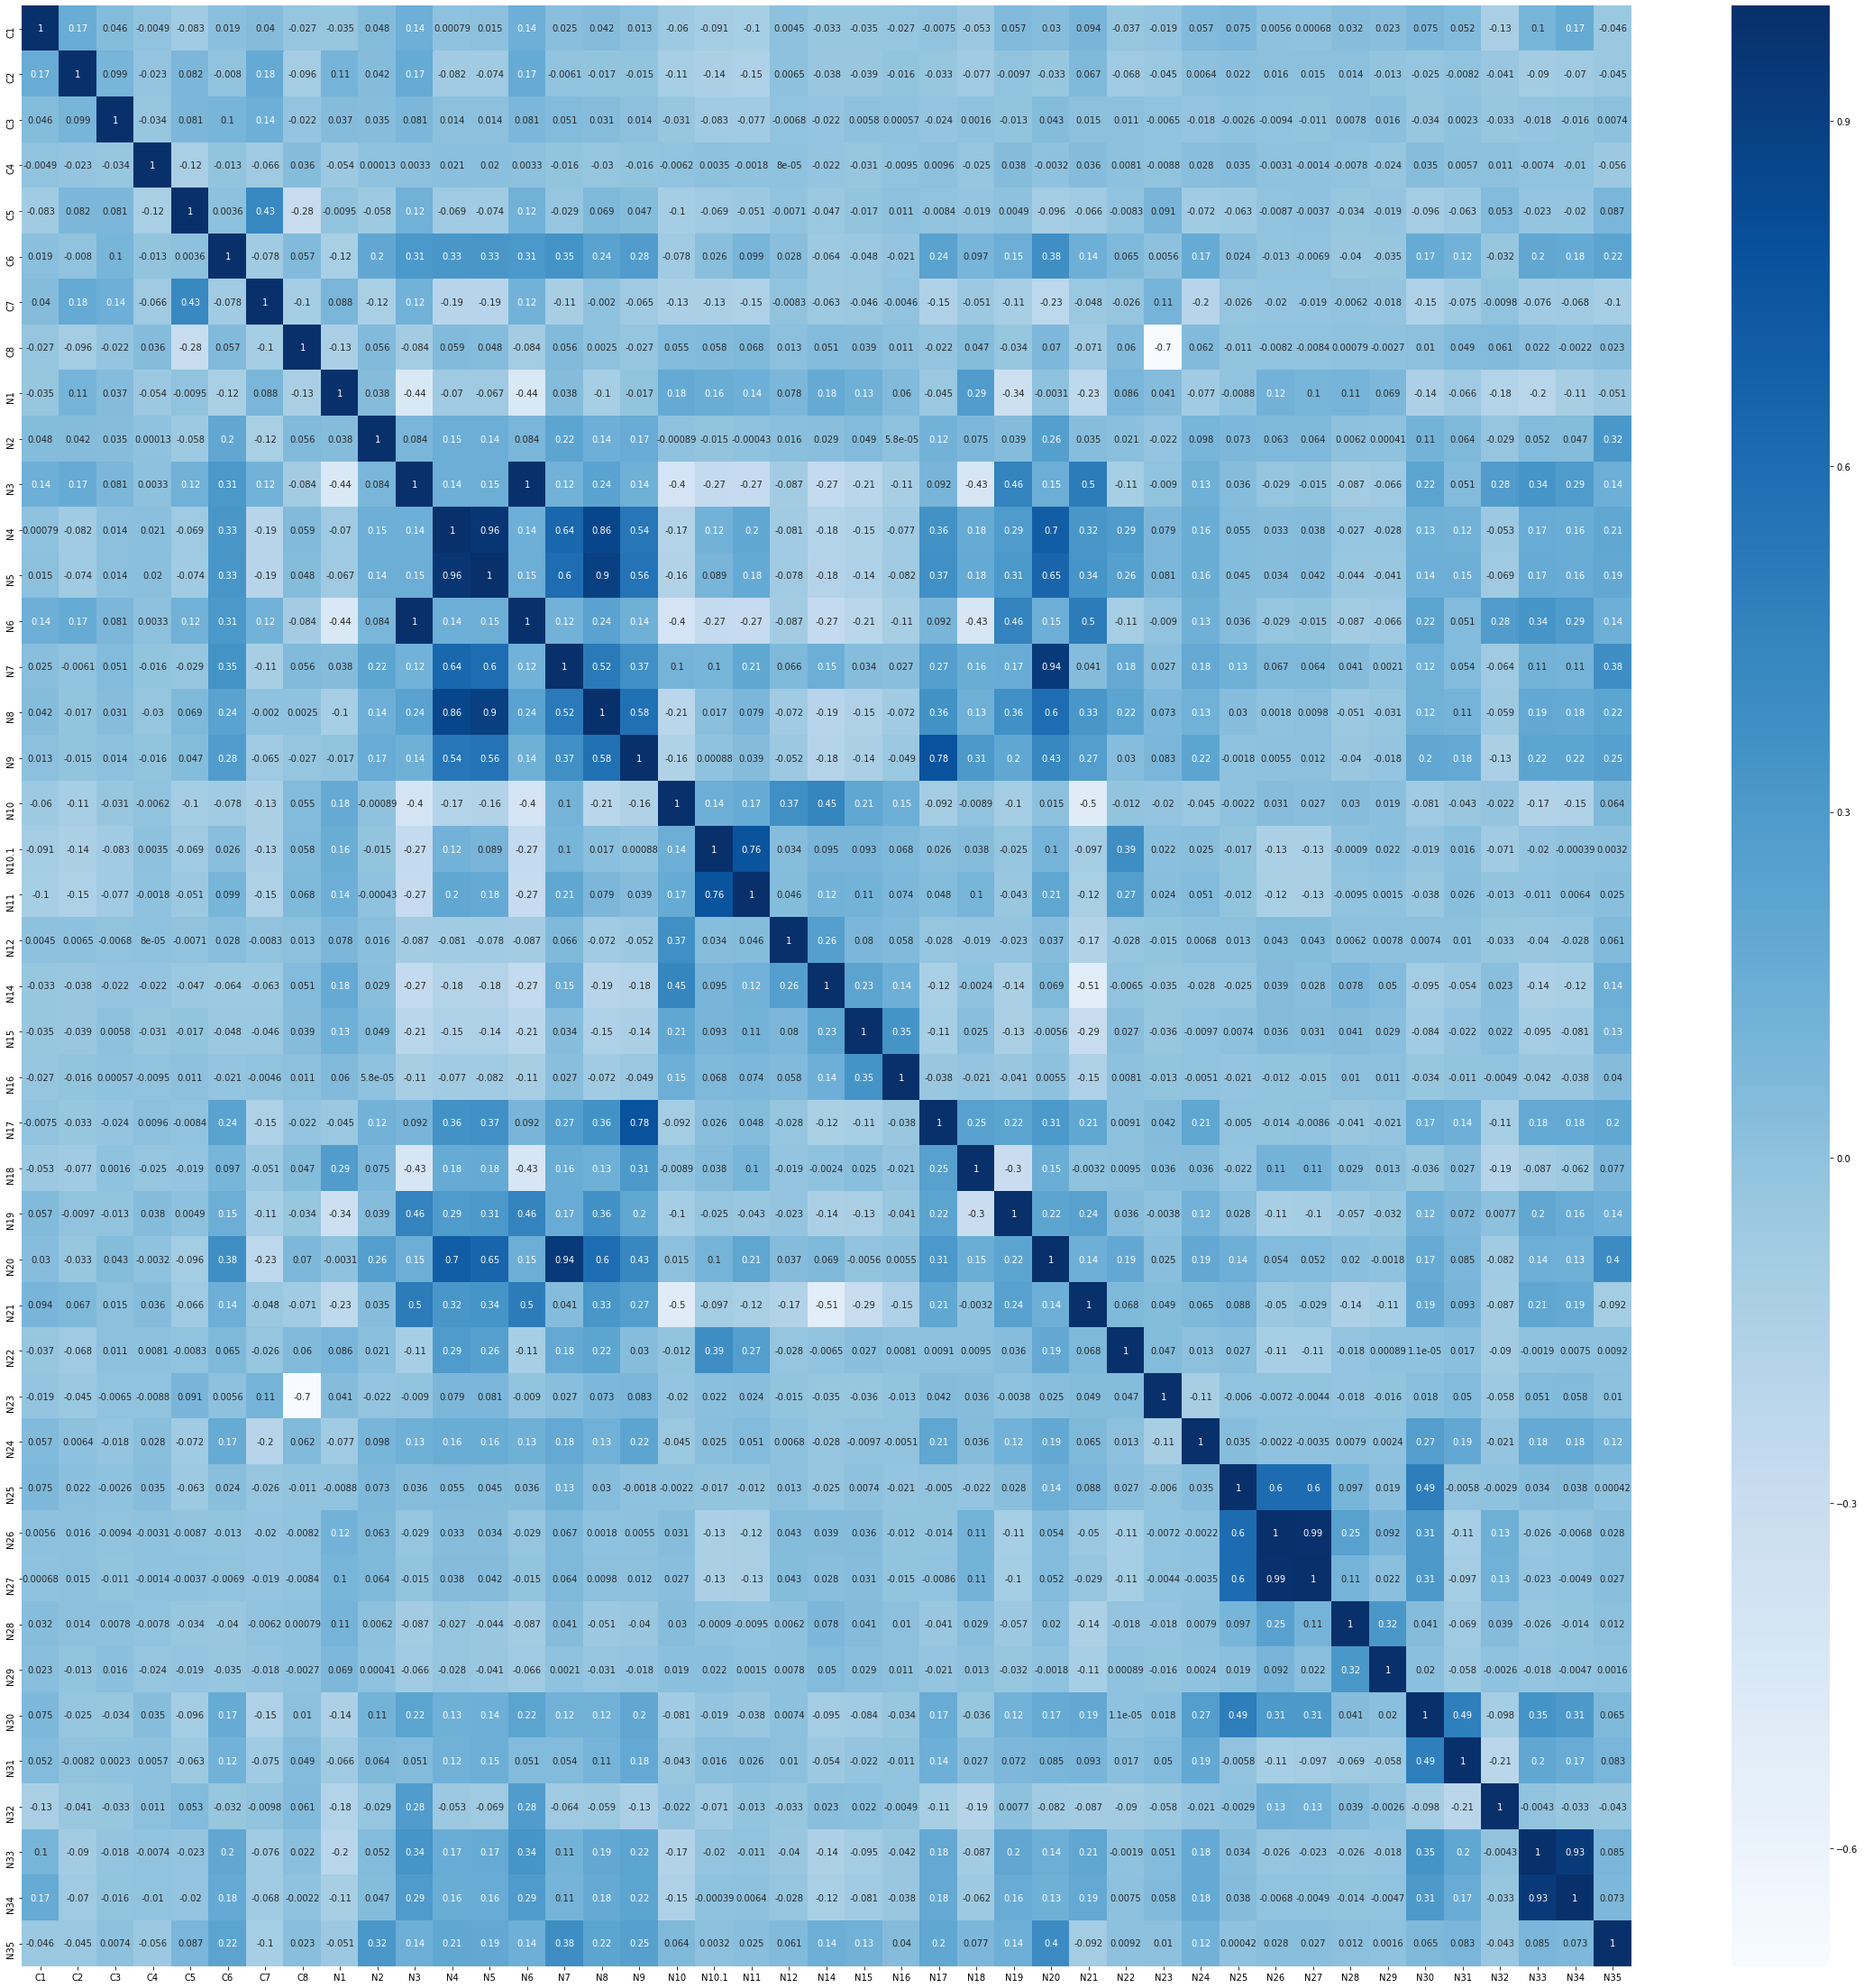

In [8]:
plt.figure(figsize = (40,40))
sb.heatmap(X_train.corr(), cmap="Blues", annot=True)
plt.show()

In [9]:
corr_matrix = X_train.corr().abs()

In [10]:
# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

#### Finding features having correlation greather than 90%

In [11]:
to_drop = [column for column in upper.columns if any(upper[column] > 0.90)]

In [12]:
to_drop

['N5', 'N6', 'N20', 'N27', 'N34']

#### Dropping features in the training dataset having correlation of greater than 0.9

In [13]:
X_train.drop(to_drop, axis=1, inplace=True)
X_train.shape

(33050, 38)

#### Dropping the same columns(columns that have been droppped from the train dataset having correlation of greater than 0.9) from the test dataset as well

In [14]:
X_test.drop(to_drop, axis=1, inplace=True)
X_test.shape

(11017, 38)

#### Handling missing values

In [15]:
print("Columns having null data in the train dataset:\n",X_train.columns[X_train.isnull().any()].tolist())

Columns having null data in the train dataset:
 ['N2', 'N3', 'N4', 'N7', 'N10', 'N10.1', 'N11', 'N12', 'N14', 'N15', 'N16', 'N17', 'N18', 'N19', 'N21', 'N22', 'N23', 'N25', 'N26', 'N28', 'N29', 'N30', 'N31', 'N32', 'N35']


In [16]:
print("Percentage of null data in the columns:")
print(((X_train[X_train.columns[X_train.isnull().any()]].isnull().sum())*100)/X_train.shape[0])

Percentage of null data in the columns:
N2       13.954614
N3        1.104387
N4       13.936460
N7        1.291982
N10       1.291982
N10.1     1.291982
N11       2.166415
N12      13.960666
N14       1.839637
N15       1.291982
N16      13.936460
N17      13.936460
N18      13.936460
N19      13.830560
N21      13.830560
N22      13.830560
N23       7.521936
N25      81.025719
N26      81.025719
N28      81.025719
N29      81.025719
N30      81.025719
N31      81.025719
N32      81.180030
N35       1.291982
dtype: float64


#### Finding columns having more than 80 percent of null values

In [17]:
columns_with_null_gt_80 = X_train.columns[X_train.isna().sum()/len(X_train) > 0.8]
columns_with_null_gt_80

Index(['N25', 'N26', 'N28', 'N29', 'N30', 'N31', 'N32'], dtype='object')

#### Dropping columns having more than 80 percent of null values

Dropping the columns having more than 80 percent of null data as the performance of the models after removing these columns is relatively same to the performance of models trained on the dataset wherein the null values in these columns are filled with their mean values.

Since we have no information about the column and its importance; we drop these columns as 80 percent is relatively high and also since there is no drop in performance.  

In [18]:
X_train.dropna(thresh=X_train.shape[0]*0.8,how='all',axis=1, inplace=True)
X_train.head()

,C1,C2,C3,C4,C5,C6,C7,C8,N1,N2,...,N16,N17,N18,N19,N21,N22,N23,N24,N33,N35
0,1,0,11,31,0,0,0,1,23.75,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,27.816,1750.000000,58.0,12.0
1,1,4,2,66,2,0,1,1,11.05,22.0,...,0.0,1944.0,0.06,25856.0,0.88,1.0,40.000,10833.333330,160.0,17.0
2,1,0,19,2,0,0,0,1,29.00,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,20.000,6250.000000,24.0,18.0
3,1,1,16,47,1,0,4,1,17.99,1.0,...,0.0,8244.0,0.89,1006.0,1.00,0.0,26.000,2413.666667,70.0,27.0
4,1,1,13,1,1,1,6,1,27.50,206.0,...,0.0,57532.0,0.97,3398.0,0.96,0.0,44.000,7666.666667,100.0,21.0


In [19]:
X_train.shape

(33050, 31)

#### Dropping the same columns(columns that have been droppped from the train dataset having more than 80 percent of null values) from the test dataset as well

In [20]:
X_test.drop(columns_with_null_gt_80, axis=1, inplace=True)
X_test.head()

,C1,C2,C3,C4,C5,C6,C7,C8,N1,N2,...,N16,N17,N18,N19,N21,N22,N23,N24,N33,N35
0,1,0,0,23,0,1,0,1,18.00,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,66.0,3333.333333,50.0,23.0
1,1,0,2,4,2,1,2,1,16.75,107.0,...,0.0,59435.0,0.83,12165.0,0.94,2.0,36.0,5779.833333,300.0,16.0
2,1,2,3,38,1,0,4,1,29.99,45.0,...,0.0,1996.0,0.79,504.0,0.70,2.0,48.0,3083.333333,80.0,22.0
3,1,1,28,20,2,0,2,1,17.70,20.0,...,0.0,9281.0,0.84,1428.0,0.77,0.0,36.0,5117.083333,150.0,13.0
4,1,1,15,1,3,0,5,0,28.00,2.0,...,0.0,13902.0,0.64,6324.0,0.92,2.0,NaN,0.000000,50.0,14.0


In [21]:
print("Columns having null data in the train dataset:\n",X_train.columns[X_train.isnull().any()].tolist())

Columns having null data in the train dataset:
 ['N2', 'N3', 'N4', 'N7', 'N10', 'N10.1', 'N11', 'N12', 'N14', 'N15', 'N16', 'N17', 'N18', 'N19', 'N21', 'N22', 'N23', 'N35']


#### Filling null values

After trying various methods like dropping rows with null values; filling null values with mean, median, mode; and using interpolation, it was found that by filling null values with their mean there is an improvement in the performance. So, we fill the null values with mean.

If the class labels of the test dataset would have been available we could have tried filling the null values with mean of the data in the column having the same class label. 

In [22]:
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')

In [23]:
X_train = pd.DataFrame(imputer.fit_transform(X_train), columns = X_train.columns)

In [24]:
print("Columns having null data in the train dataset:\n",X_train.columns[X_train.isnull().any()].tolist())

Columns having null data in the train dataset:
 []


#### Filling null values in the test dataset with their mean 

In [25]:
X_test = pd.DataFrame(imputer.fit_transform(X_test), columns = X_test.columns)

In [26]:
print("Columns having null data in the test dataset:\n",X_test.columns[X_test.isnull().any()].tolist())

Columns having null data in the test dataset:
 []


#### Checking the distribution of the class labels

<AxesSubplot:ylabel='Dependent_Variable'>

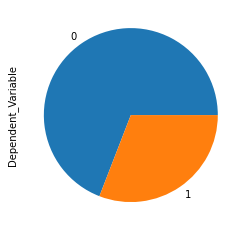

In [27]:
Y_train['Dependent_Variable'].value_counts().plot.pie(figsize=(6,4))

We can see that the training data is highly imbalanced 

#### Using SMOTE (Synthetic Minority Oversampling Technique) to balance the class distribution by randomly increasing minority class examples by replicating them

In [28]:
smote = SMOTE(sampling_strategy='minority')
X_train, Y_train = smote.fit_resample(X_train, Y_train)

In [29]:
print(X_train.shape)
print(Y_train.shape)

(45688, 31)
(45688, 1)


<AxesSubplot:ylabel='Dependent_Variable'>

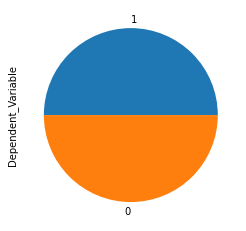

In [30]:
Y_train['Dependent_Variable'].value_counts().plot.pie(figsize=(6,4))

In [31]:
X_train.head(2)

,C1,C2,C3,C4,C5,C6,C7,C8,N1,N2,...,N16,N17,N18,N19,N21,N22,N23,N24,N33,N35
0,1.0,0.0,11.0,31.0,0.0,0.0,0.0,1.0,23.75,81.34271,...,0.023203,15820.726797,0.528907,11037.365322,0.857199,0.906422,27.816,1750.00000,58.0,12.0
1,1.0,4.0,2.0,66.0,2.0,0.0,1.0,1.0,11.05,22.00000,...,0.000000,1944.000000,0.060000,25856.000000,0.880000,1.000000,40.000,10833.33333,160.0,17.0


In [32]:
Y_train.head(2)

,Dependent_Variable
0,1
1,0


In [33]:
X_test.head(2)

,C1,C2,C3,C4,C5,C6,C7,C8,N1,N2,...,N16,N17,N18,N19,N21,N22,N23,N24,N33,N35
0,1.0,0.0,0.0,23.0,0.0,1.0,0.0,1.0,18.00,81.279492,...,0.024032,15937.365096,0.53204,10639.636706,0.85539,0.909596,66.0,3333.333333,50.0,23.0
1,1.0,0.0,2.0,4.0,2.0,1.0,2.0,1.0,16.75,107.000000,...,0.000000,59435.000000,0.83000,12165.000000,0.94000,2.000000,36.0,5779.833333,300.0,16.0


#### Preprocessing the numerical values

After trying both normalizing the numerical values and standardizing the numerical values, it was found that standardizing works better.
So, we standardize the numerical values in the training and test dataset

In [34]:
scaler = preprocessing.StandardScaler()

In [35]:
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns)
X_train.head()

,C1,C2,C3,C4,C5,C6,C7,C8,N1,N2,...,N16,N17,N18,N19,N21,N22,N23,N24,N33,N35
0,-0.302789,-0.719094,-0.158062,1.156846,-1.319561,-0.961579,-1.452604,0.30378,0.367485,0.006885,...,-0.020671,-0.002134,-0.033999,0.048639,0.047442,-0.040250,-0.219873,-0.562063,-0.665746,-1.079675
1,-0.302789,0.512251,-0.946089,3.541748,0.216968,-0.961579,-0.986711,0.30378,-1.272592,-0.780638,...,-0.159050,-0.445113,-1.484005,0.831825,0.189252,0.043584,-0.136478,1.071854,0.336030,-0.365189
2,-0.302789,-0.719094,0.542405,-0.819216,-1.319561,-0.961579,-1.452604,0.30378,1.045470,0.006885,...,-0.020671,-0.002134,-0.033999,0.048639,0.047442,-0.040250,-0.273371,0.247401,-0.999671,-0.222292
3,-0.302789,-0.411258,0.279730,2.247087,-0.551297,-0.961579,0.410968,0.30378,-0.376361,-1.059325,...,-0.159050,-0.244002,1.082613,-0.481532,0.935580,-0.852291,-0.232303,-0.442682,-0.547890,1.063782
4,-0.302789,-0.411258,0.017055,-0.887356,-0.551297,1.120599,1.342754,0.30378,0.851760,1.661184,...,-0.159050,1.329392,1.329998,-0.355112,0.686804,-0.852291,-0.109100,0.502232,-0.253250,0.206399


In [36]:
X_test = pd.DataFrame(scaler.transform(X_test), columns = X_test.columns)
X_test.head()

,C1,C2,C3,C4,C5,C6,C7,C8,N1,N2,...,N16,N17,N18,N19,N21,N22,N23,N24,N33,N35
0,-0.302789,-0.719094,-1.121206,0.611726,-1.319561,1.120599,-1.452604,0.303780,-0.375070,0.006046,...,-0.015731,0.001589,-0.024310,0.027619,0.036191,-0.037407,0.041482,-0.277252,-0.744316,0.492193
1,-0.302789,-0.719094,-0.946089,-0.682936,0.216968,1.120599,-0.520818,0.303780,-0.536494,0.347378,...,-0.159050,1.390140,0.897075,0.108236,0.562416,0.939458,-0.163857,0.162827,1.711017,-0.508087
2,-0.302789,-0.103421,-0.858530,1.633827,-0.551297,-0.961579,0.410968,0.303780,1.173318,-0.475411,...,-0.159050,-0.443453,0.773382,-0.508063,-0.930240,0.939458,-0.081721,-0.322222,-0.449676,0.349296
3,-0.302789,-0.411258,1.330432,0.407305,0.216968,-0.961579,-0.520818,0.303780,-0.413812,-0.807180,...,-0.159050,-0.210898,0.927998,-0.459229,-0.494882,-0.852291,-0.163857,0.043611,0.237817,-0.936778
4,-0.302789,-0.411258,0.192171,-0.887356,0.985232,-0.961579,0.876861,-3.567258,0.916330,-1.046054,...,-0.159050,-0.063385,0.309535,-0.200468,0.438028,0.939458,-0.015228,-0.876855,-0.744316,-0.793881


## Implementing Machine Learning Models

### Logisitic Regression

In [37]:
parameters = {"C":[10**-x for x in range(-3,3)]}

model = LogisticRegression(penalty='l2', random_state=0)
clf_log = GridSearchCV(model, parameters, cv=10, scoring='roc_auc', n_jobs=-1)
clf_log.fit(X_train,Y_train.values.ravel())

print("Best estimator=", clf_log.best_estimator_)
print("Best score =", clf_log.best_score_)

Best estimator= LogisticRegression(C=100, random_state=0)
Best score = 0.7502915727859788


In [38]:
model_log = LogisticRegression(C= clf_log.best_params_['C'], penalty='l2', random_state=0)
model_log.fit(X_train, Y_train.values.ravel())

Y_pred_log = model_log.predict_proba(X_test)

### Decision Trees

In [39]:
model_DT = DecisionTreeClassifier(random_state=0)
parameters={'criterion': ['gini','entropy','log_loss'] ,'min_samples_split':[4,8,10,12], 'max_features':['sqrt','log2','None']}
clf_DT = GridSearchCV(model_DT, parameters, cv=10, scoring='roc_auc', n_jobs=-1)
clf_DT.fit(X_train, Y_train.values.ravel())

print("Best estimator=", clf_DT.best_estimator_)
print("Best score=", clf_DT.best_score_)

Best estimator= DecisionTreeClassifier(criterion='entropy', max_features='sqrt',
                       min_samples_split=12, random_state=0)
Best score= 0.7673087437186636


In [40]:
model_DT = RandomForestClassifier(criterion = clf_DT.best_params_['criterion']
                                  , min_samples_split= clf_DT.best_params_['min_samples_split']
                                  , max_features = clf_DT.best_params_['max_features']
                                  , random_state=0)
model_DT.fit(X_train, Y_train.values.ravel())

Y_pred_DT = model_DT.predict_proba(X_test)

### Random Forest

In [43]:
model_RF = RandomForestClassifier(random_state=0)
parameters={'criterion': ['gini','entropy','log_loss']
            , 'min_samples_split':[4,8,10,12]
            , 'n_estimators':[350, 400, 500]
            , 'max_features':['sqrt','log2','None']}
clf_RF = GridSearchCV(model_RF, parameters, cv=10, scoring='roc_auc', n_jobs=-1)
clf_RF.fit(X_train, Y_train.values.ravel())

print("Best estimator=", clf_RF.best_estimator_)
print("Best score=", clf_RF.best_score_)

Best estimator= RandomForestClassifier(criterion='entropy', max_features='sqrt',
                       min_samples_split=4, n_estimators=500, random_state=0)
Best score= 0.9025488993051087


In [44]:
model_RF = RandomForestClassifier(criterion = clf_RF.best_params_['criterion']
                                  , min_samples_split= clf_RF.best_params_['min_samples_split']
                                  , max_features = clf_RF.best_params_['max_features']
                                  , n_estimators= clf_RF.best_params_['n_estimators']
                                 , random_state=0)
model_RF.fit(X_train, Y_train.values.ravel())

Y_pred_RF = model_RF.predict_proba(X_test)

### Gradient Boosting Decision Trees

In [46]:
model_GBDT = GradientBoostingClassifier(random_state=0)
parameters = {'learning_rate':[0.1, 0.2, 0.3, 0.4]
              , 'min_samples_split':[4,8,10,12]
              , 'n_estimators':[200, 300, 400, 500]
              , 'max_features':['sqrt','log2','None']}
clf_GBDT = GridSearchCV(model_GBDT, parameters, cv=10, scoring='roc_auc', n_jobs=-1)
clf_GBDT.fit(X_train, Y_train.values.ravel())

print("Best estimator=", clf_GBDT.best_estimator_)
print("Best score=", clf_GBDT.best_score_)

Best estimator= GradientBoostingClassifier(learning_rate=0.2, max_features='sqrt',
                           min_samples_split=10, n_estimators=500,
                           random_state=0)
Best score= 0.8931136232903331


In [47]:
model_GBDT = GradientBoostingClassifier(learning_rate= clf_GBDT.best_params_['learning_rate']
                                        , min_samples_split= clf_GBDT.best_params_['min_samples_split']
                                        , n_estimators= clf_GBDT.best_params_['n_estimators']
                                        , max_features= clf_GBDT.best_params_['max_features']
                                       
                                       )
model_GBDT.fit(X_train, Y_train.values.ravel())

Y_pred_GBDT = model_GBDT.predict_proba(X_test)

### Summary

In [66]:
# assigning data
table_data = [("Logistic Regression", clf_log.best_score_)
              ,("Decision Trees", clf_DT.best_score_)
              ,("Random Forest", clf_RF.best_score_)
              ,("Gradient Boosting Decision Trees", clf_GBDT.best_score_)             
             ]

# creating header
table_head = ["Model", "Mean cross-validated roc-auc score calculated using GridSearcCV"]

# displaying the table
print(tabulate(table_data, headers=table_head, tablefmt="grid"))

+----------------------------------+-------------------------------------------------------------------+
| Model                            |   Mean cross-validated roc-auc score calculated using GridSearcCV |
+==================================+===================================================================+
| Logistic Regression              |                                                          0.750292 |
+----------------------------------+-------------------------------------------------------------------+
| Decision Trees                   |                                                          0.767309 |
+----------------------------------+-------------------------------------------------------------------+
| Random Forest                    |                                                          0.902549 |
+----------------------------------+-------------------------------------------------------------------+
| Gradient Boosting Decision Trees |                   

#### As we can see that the mean cross-validated roc-auc score using Random Forest is the highest, we will use Random Forest model to predict the class labels of the test dataset

## Predicting Dependent_Variable using RandomForest model

In [71]:
Class_1_Probability_RF = pd.DataFrame(Y_pred_RF, columns=model_DT.classes_)[1].to_numpy()
Class_1_Probability_RF

array([0.5236    , 0.3793    , 0.34496667, ..., 0.42028571, 0.3007    ,
       0.22995   ])

In [72]:
result_df = pd.DataFrame(X_test_df['Unique_ID'].copy())

In [73]:
result_df['Class_1_Probability'] = Class_1_Probability_RF
result_df.head()

,Unique_ID,Class_1_Probability
0,Candidate_1602,0.523600
1,Candidate_29650,0.379300
2,Candidate_31061,0.344967
3,Candidate_5768,0.203617
4,Candidate_27059,0.535033


## Dataframe to csv

In [74]:
result_df.to_csv(r"D:\Monsoon Credittech\sample_submission.csv", index = False)